In [11]:
#import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sklearn.datasets
import pandas as pd
import umap
from sklearn.datasets import load_digits
from matplotlib.gridspec import GridSpec
from ivis import Ivis
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.decomposition import PCA


In [2]:
#a function to re-order datafiles in an alphanumerical order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
#load in data in .jpg file formats
DATADIR = "example_data" #path to your data directory
CATEGORIES = ["ch02_jpg"] #select the channel

IMG_SIZE = 80

data=[]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    dirlist = sorted_alphanumeric(os.listdir(path))
    for img in dirlist:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        data.append([new_array])

In [4]:
new_data = np.concatenate(data, axis=0 ) #flatten the data array
p = new_data.reshape((24081,80*80)) #resize the data array to shape of size: n_number_of_files, x-axis-pixels * y-axis-pixels
p

array([[1, 0, 0, ..., 0, 0, 0],
       [4, 4, 2, ..., 0, 0, 0],
       [0, 2, 5, ..., 0, 0, 0],
       ...,
       [6, 6, 6, ..., 3, 2, 3],
       [5, 5, 4, ..., 3, 4, 4],
       [3, 4, 5, ..., 4, 3, 4]], dtype=uint8)

In [5]:
np.random.seed(42) #set seed if needed for reproducibility

In [7]:
#2D embedding of the pixel data with UMAP
fit = umap.UMAP(n_neighbors=25,n_components=2)
%time u = fit.fit_transform(p)

Wall time: 33.7 s


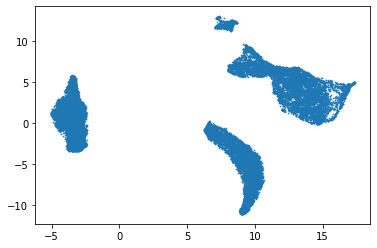

In [8]:
plt.scatter(u[:,0], u[:,1],s=0.4)

Wall time: 13.6 s


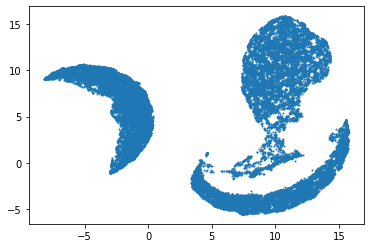

In [10]:
#2D embedding of the numerical data with UMAP
numerical = pd.read_csv("example_data\merged",sep="\t",index_col=0,decimal=',')
fit_n = umap.UMAP(n_neighbors=25)
%time u_n = fit_n.fit_transform(numerical)
plt.scatter(u_n[:,0], u_n[:,1],s=1)

In [12]:
#preprocess with PCA
pca_dims = PCA()
pca_dims.fit(p)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 #calculate the number of PCs to retain 95% of the variance in the dataset

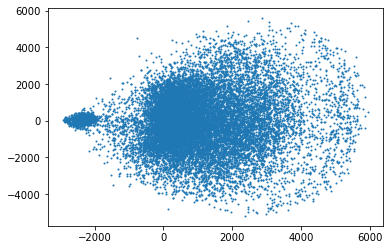

In [13]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(p)
X_recovered = pca.inverse_transform(X_reduced) #reconstrust the image from the retained PCs
plt.scatter(X_reduced[:,0], X_reduced[:,1],s=1) #plot results of PCA

Wall time: 11.2 s


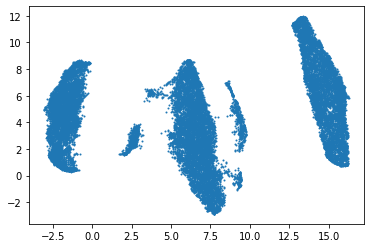

In [14]:
##Run UMAP embedding on precopmupted PCs from channels 2 and 4
merged = pd.read_csv("example_data/pollen3type_pca_reduced_merged",sep="\t",index_col=0,decimal='.')
fit_m = umap.UMAP(n_neighbors=15)
%time u_m = fit_m.fit_transform(merged)
plt.scatter(u_m[:,0], u_m[:,1],s=1)


In [ ]:
#prepare connectivity plots
%time mapper = umap.UMAP(set_op_mix_ratio=0.15).fit(merged)
umap.plot.diagnostic(mapper, diagnostic_type='local_dim') #run diagnostics on the embedding


In [ ]:
umap.plot.connectivity(mapper,theme='fire')

In [ ]:
#subsample the data
n = 2000  # for 2 random indices
index = np.random.choice(p.shape[0], n, replace=False) 
x_random = p[index]
idx = x_random
fit = umap.UMAP(n_neighbors=15)
%time u2 = fit.fit_transform(idx)
plt.scatter(u2[:,0], u2[:,1],s=1)